In [24]:
# Python Modules
import numpy as np
import pandas as pd
import os


# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Utils
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Modeling
from sklearn.linear_model import LinearRegression
import pmdarima as pm
import statsmodels.api as sm
from pyod.models.lof import LOF
import ruptures as rpt
from sklearn.cluster import KMeans

%matplotlib inline
%load_ext nb_black

plt.rcParams["figure.figsize"] = (14, 7)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

-------------

## Read in Data

In [2]:
def read_zori(filename):
    """
    Read ZORI Data

    Data from: https://www.zillow.com/research/methodology-zori-repeat-rent-27092/
    """
    zori_colnames = (pd.read_csv(filename, nrows=1)).columns
    keep_cols = ["RegionName", "SizeRank", "State", "City", "Metro", "CountyName"]
    keep_cols.extend(list(zori_colnames[9:]))
    date_cols = zori_colnames[9:]
    dtype_map = {}
    for kc in ["RegionName", "SizeRank", "State", "City", "Metro", "CountyName"]:
        dtype_map[kc] = str
    for dc in date_cols:
        dtype_map[dc] = np.float64

    df = pd.read_csv(filename, usecols=keep_cols, dtype=dtype_map)
    df.rename(columns={"RegionName": "zipcode"}, inplace=True)

    df = df.melt(
        id_vars=["zipcode", "SizeRank", "State", "City", "Metro", "CountyName"],
        var_name="month",
        value_name="zori",
    )

    df.month = pd.to_datetime(df.month)
    df.sort_values(["zipcode", "month"], inplace=True)
    return df


zori = read_zori("../data/zillow/Zip_zori_sm_month.csv")
zori.head()

,zipcode,SizeRank,State,City,Metro,CountyName,month,zori
3083,01002,3602,MA,Amherst,"Springfield, MA",Hampshire County,2015-03-31,NaN
8983,01002,3602,MA,Amherst,"Springfield, MA",Hampshire County,2015-04-30,NaN
14883,01002,3602,MA,Amherst,"Springfield, MA",Hampshire County,2015-05-31,NaN
20783,01002,3602,MA,Amherst,"Springfield, MA",Hampshire County,2015-06-30,NaN
26683,01002,3602,MA,Amherst,"Springfield, MA",Hampshire County,2015-07-31,NaN


<IPython.core.display.Javascript object>

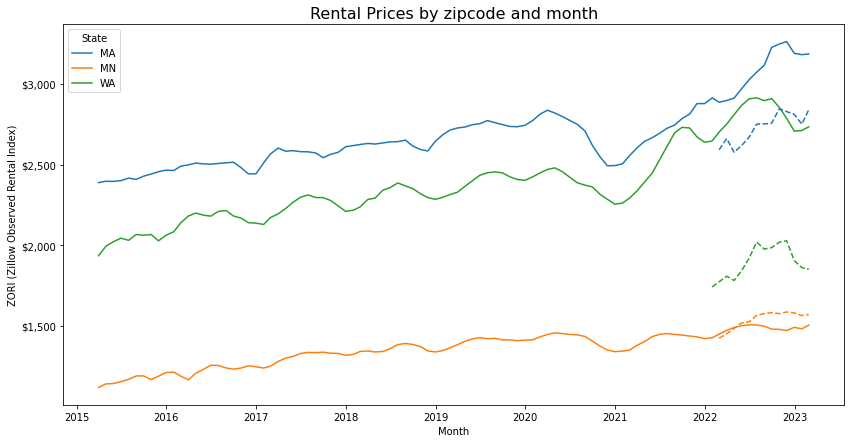

<IPython.core.display.Javascript object>

In [3]:
fig, ax = plt.subplots(1, 1)
["02215", "02122", "98004", "98020", "55408", "55113"]
g = sns.lineplot(
    data=zori[zori.zipcode.isin(["02215", "98004", "55408"])],
    x="month",
    y="zori",
    # marker="o",
    hue="State",
    linestyle="solid",
    ax=ax,
)
g2 = sns.lineplot(
    data=zori[zori.zipcode.isin(["02122", "98020", "55113"])],
    x="month",
    y="zori",
    # marker="o",
    hue="State",
    linestyle="dashed",
    ax=ax,
    legend=False,
)

fmt = "${x:,.0f}"
tick = mtick.StrMethodFormatter(fmt)
_ = ax.yaxis.set_major_formatter(tick)
_ = g.set_ylabel("ZORI (Zillow Observed Rental Index)")
_ = g.set_xlabel("Month")
_ = g.set_title("Rental Prices by zipcode and month", fontsize=16)

The graph above shows the ZORI for six different time series.

I'm plotting full time series since 2015 for three different metro areas (Boston, Minneapolis, Bellevue/Seattle).
For each metro area, the full time series represents a zip code that we could think of as the city center. There are also secondary time series that starts around 2022. These time series are taken from suburbs of the main city center.  The idea here is that we don't have a long enough history for the short time series to fit TS models.

Suppose your company has operations in Boston, Bellevue, and Minneapolis proper but now wants to expand into the suburbs.  We need to come up with a reasonable way to forecast for these three areas.

-------------------

In [5]:
def get_complete(df):
    df["missing_ind"] = df.zori.isna()
    missing_df = (
        df.groupby("zipcode").agg(count_missing=("missing_ind", "sum")).reset_index()
    )
    missing_df = missing_df[missing_df.count_missing == 0]
    del df["missing_ind"]
    del missing_df["count_missing"]
    df = df.merge(missing_df, on=["zipcode"], how="inner")

    return df


zori_complete = get_complete(zori)

<IPython.core.display.Javascript object>

In [6]:
def lr_data_prep(df):
    df["time_periods"] = np.round(
        (df.month - df.month.min()) / np.timedelta64(1, "M")
    ).astype("int")
    return df


def lr_slopes(df):
    df["time_periods"] = np.round(
        (df.month - df.month.min()) / np.timedelta64(1, "M")
    ).astype("int")

    tuples = []
    for zc in df.zipcode.unique():
        lr_df = df[df.zipcode == zc]

        reg = LinearRegression().fit(X=lr_df[["time_periods"]], y=lr_df.zori)
        intercept = reg.intercept_
        slope = reg.coef_[0]
        tuples.append((zc, intercept, slope))

    results = pd.DataFrame(tuples, columns=["zipcode", "intercept", "slope"])

    return results


reg_results = lr_slopes(zori_complete)

<IPython.core.display.Javascript object>

In [7]:
zori_complete = zori_complete.merge(reg_results, on="zipcode", how="left")
zori_complete["zori_pred_linreg"] = (
    zori_complete["intercept"] + zori_complete["slope"] * zori_complete["time_periods"]
)

<IPython.core.display.Javascript object>

<AxesSubplot: xlabel='month', ylabel='zori'>

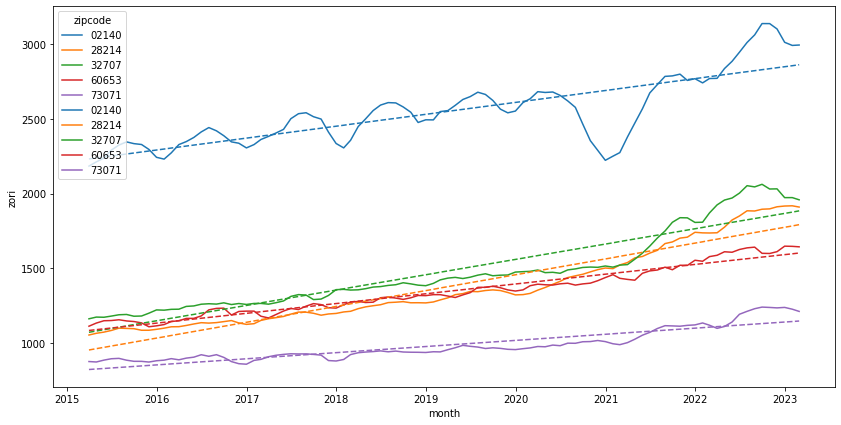

<IPython.core.display.Javascript object>

In [11]:
zcs = np.random.choice(zori_complete.zipcode.unique(), 5, replace=False)


sns.lineplot(
    data=zori_complete[zori_complete.zipcode.isin(zcs)],
    x="month",
    y="zori",
    hue="zipcode",
)
sns.lineplot(
    data=zori_complete[zori_complete.zipcode.isin(zcs)],
    x="month",
    y="zori_pred_linreg",
    hue="zipcode",
    linestyle="dashed",
)

Text(0.5, 1.0, 'Histogram of Rent Growth Rate by Zipcodes')

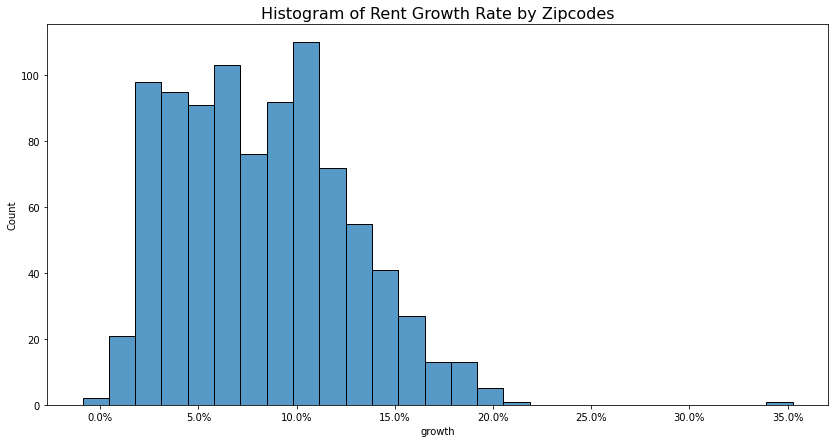

<IPython.core.display.Javascript object>

In [12]:
reg_results["growth"] = 12 * reg_results["slope"] / reg_results["intercept"]
# fig, ax = plt.subplots(1,1)
g = sns.histplot(data=reg_results, x="growth")
g.xaxis.set_major_formatter(mtick.PercentFormatter(1))
g.set_title("Histogram of Rent Growth Rate by Zipcodes", fontsize=16)

-----------------

## Variability

Get the Sigma2 estimate from an arima model for each zip code

In [14]:
def arima_stds(df):
    df["time_periods"] = np.round(
        (df.month - df.month.min()) / np.timedelta64(1, "M")
    ).astype("int")

    if os.path.exists("../arima_results.csv"):
        res = pd.read_csv(
            "../arima_results.csv",
            dtype={"zipcode": str, "order": str, "sigma2": np.float64},
        )
        return res

    tuples = []
    for zc in df.zipcode.unique():
        print(zc)
        zcd = df[df.zipcode == zc].copy()

        zcd["zori_diff"] = zcd.zori.diff()
        zcd["zori_log"] = np.log(zcd.zori)
        zcd["zori_lr"] = zcd.zori_log.diff()

        zcd.set_index("month")

        # Fit an ARIMA model using the pmdarima auto_arima function
        model = pm.auto_arima(
            zcd.iloc[1:].zori_lr,
            seasonal=False,
            stationary=True,
            max_p=4,
            max_q=4,
            error_action="ignore",
        )
        # print(model.params())

        # Print the optimal values of p and q determined by the auto_arima function
        # print("Optimal values of p and q:", model.order)
        tuples.append((zcd.zipcode, model.order, model.params()["sigma2"]))

    results = pd.DataFrame(tuples, columns=["zipcode", "order", "sigma2"])

    return results


arima_results = arima_stds(zori_complete)
arima_results.to_csv("../arima_results.csv", index=False)
arima_results

,zipcode,order,sigma2
0,02111,"(4, 0, 3)",0.000121
1,02113,"(2, 0, 2)",0.000207
2,02114,"(1, 0, 2)",0.000084
3,02115,"(1, 0, 2)",0.000058
4,02116,"(1, 0, 3)",0.000076
...,...,...,...
911,98374,"(3, 0, 2)",0.000052
912,98375,"(2, 0, 2)",0.000055
913,98405,"(3, 0, 3)",0.000101
914,98516,"(0, 0, 4)",0.000049


<IPython.core.display.Javascript object>

--------------

In [15]:
combined_results = pd.merge(reg_results, arima_results, on=["zipcode"], how="outer")
combined_results

,zipcode,intercept,slope,growth,order,sigma2
0,02111,3052.768364,5.633136,0.022143,"(4, 0, 3)",0.000121
1,02113,2068.644654,4.715239,0.027353,"(2, 0, 2)",0.000207
2,02114,2569.939636,4.489854,0.020965,"(1, 0, 2)",0.000084
3,02115,2531.926365,5.244597,0.024857,"(1, 0, 2)",0.000058
4,02116,2538.644342,4.708643,0.022257,"(1, 0, 3)",0.000076
...,...,...,...,...,...,...
911,98374,1327.293542,10.940977,0.098917,"(3, 0, 2)",0.000052
912,98375,1344.596802,13.162511,0.117470,"(2, 0, 2)",0.000055
913,98405,810.850455,8.641404,0.127887,"(3, 0, 3)",0.000101
914,98516,1266.024589,10.886795,0.103190,"(0, 0, 4)",0.000049


<IPython.core.display.Javascript object>

In [16]:
combined_results.head()
ss = StandardScaler()
combined_results[["std_growth", "std_sigma2"]] = ss.fit_transform(
    combined_results[["growth", "sigma2"]]
)

<IPython.core.display.Javascript object>

<AxesSubplot: xlabel='std_sigma2', ylabel='std_growth'>

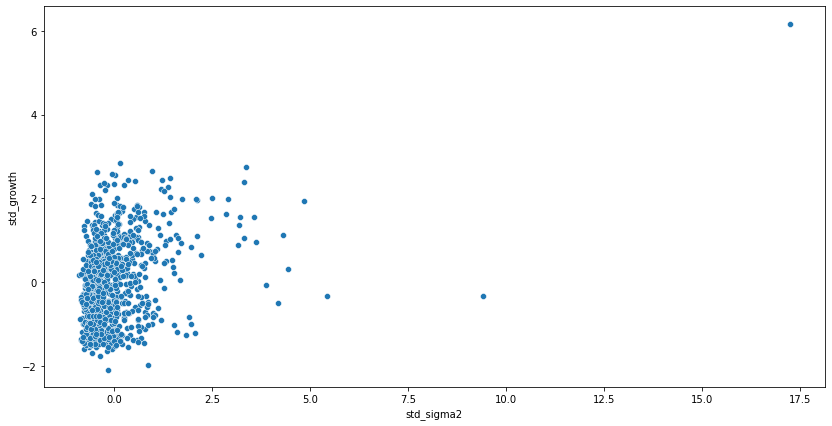

<IPython.core.display.Javascript object>

In [17]:
sns.scatterplot(
    data=combined_results,
    x="std_sigma2",
    y="std_growth",
)

------------------

## Find Anomalies

    zipcode   intercept     slope    growth      order    sigma2  std_growth  \
782   89509  465.311232  13.67304  0.352617  (0, 0, 3)  0.001269    6.169075   

     std_sigma2  
782   17.226075  


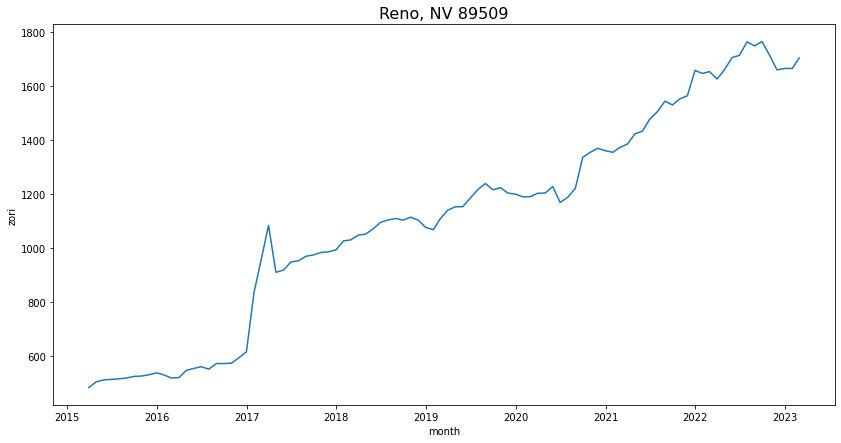

<IPython.core.display.Javascript object>

In [18]:
print(combined_results[combined_results.growth > 0.30])
g = sns.lineplot(
    data=zori_complete[zori_complete.zipcode == "89509"], x="month", y="zori"
)
_ = g.set_title("Reno, NV 89509", fontsize=16)

In [19]:
lof_data = combined_results[["zipcode", "std_growth", "std_sigma2"]].copy()
lof_data.set_index("zipcode", inplace=True)

clf = LOF(contamination=0.05, leaf_size=10)
clf.fit(lof_data)
lof_data["local_outlier_factor"] = clf.decision_scores_
lof_data["outlier"] = clf.labels_

lof_data

,std_growth,std_sigma2,local_outlier_factor,outlier
zipcode,,,,
02111,-1.377942,0.595964,1.305560,0
02113,-1.258971,1.842566,2.051646,1
02114,-1.404850,0.058793,1.021967,0
02115,-1.315972,-0.316710,1.023879,0
02116,-1.375330,-0.055698,0.974374,0
...,...,...,...,...
98374,0.375340,-0.402457,1.006984,0
98375,0.799043,-0.365650,1.013638,0
98405,1.036919,0.298462,0.971365,0


<IPython.core.display.Javascript object>

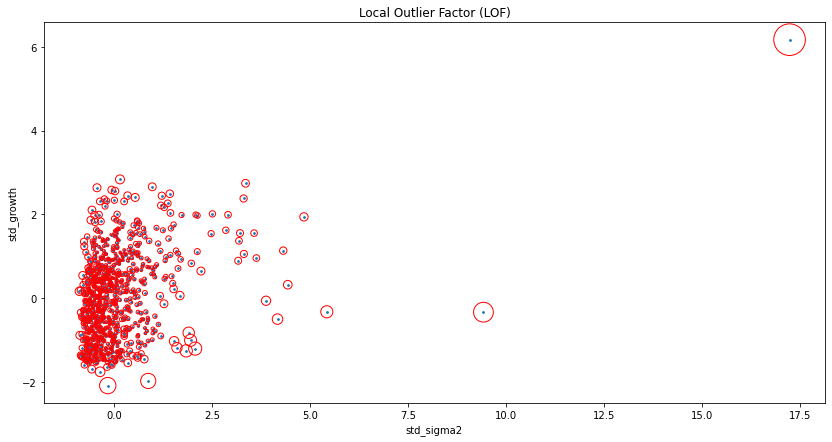

<IPython.core.display.Javascript object>

In [20]:
plt.title("Local Outlier Factor (LOF)")
plt.scatter(lof_data.loc[:, 'std_sigma2'], lof_data.loc[:,'std_growth'], s=3.0, label="Data points")
outlier_scaler = MinMaxScaler()
radius = outlier_scaler.fit_transform(lof_data[['local_outlier_factor']])
plt.scatter(
   lof_data.loc[:, 'std_sigma2'],
    lof_data.loc[:,'std_growth'],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.xlabel('std_sigma2')
plt.ylabel('std_growth')

plt.show()


In [21]:
anomaly_zips = lof_data.sort_values("local_outlier_factor", ascending=False).iloc[:5,]
az = anomaly_zips.reset_index().zipcode

plot_data = zori_complete[zori_complete.zipcode.isin(az)].copy()
anomaly_zips

,std_growth,std_sigma2,local_outlier_factor,outlier
zipcode,,,,
89509,6.169075,17.226075,8.219417,1
22315,-0.336150,9.421304,3.795271,1
94109,-2.088752,-0.157660,2.897566,1
94107,-1.977436,0.873966,2.630682,1
11355,-1.205772,2.071038,2.209651,1


<IPython.core.display.Javascript object>

In [29]:
arima_results[arima_results.zipcode == "11355"]

,zipcode,order,sigma2
115,11355,"(0, 0, 3)",0.000223


<IPython.core.display.Javascript object>

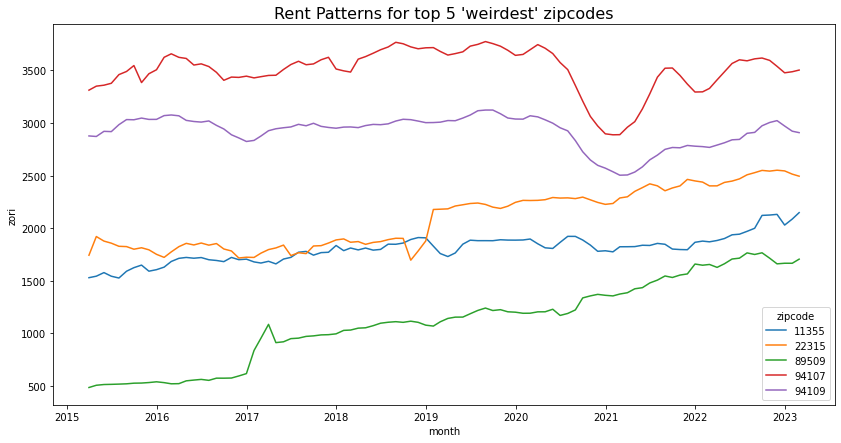

<IPython.core.display.Javascript object>

In [22]:
g = sns.lineplot(data=plot_data, x="month", y="zori", hue="zipcode")
_ = g.set_title("Rent Patterns for top 5 'weirdest' zipcodes", fontsize=16)

In [27]:
lof_data[lof_data.index.isin(anomaly_zips.index)]

,std_growth,std_sigma2,local_outlier_factor,outlier
zipcode,,,,
11355,-1.205772,2.071038,2.209651,1
22315,-0.336150,9.421304,3.795271,1
89509,6.169075,17.226075,8.219417,1
94107,-1.977436,0.873966,2.630682,1
94109,-2.088752,-0.157660,2.897566,1


<IPython.core.display.Javascript object>

Zip codes 94107 and 94109 have not recovered from Covid

Zip codes 22315 and 89509 have had massive change points

Not sure what is going on with 11355

In [35]:
combined_results[
    (combined_results.std_growth < -1.0) & (combined_results.std_sigma2 > 1.5)
]

,zipcode,intercept,slope,growth,order,sigma2,std_growth,std_sigma2
1,02113,2068.644654,4.715239,0.027353,"(2, 0, 2)",0.000207,-1.258971,1.842566
16,02141,2395.190772,7.459641,0.037373,"(0, 0, 3)",0.000186,-1.030134,1.533420
24,02445,2640.361249,8.437084,0.038345,"(1, 0, 0)",0.000215,-1.007935,1.953825
115,11355,1615.256312,3.995357,0.029682,"(0, 0, 3)",0.000223,-1.205772,2.071038
562,75219,1543.197036,3.940489,0.030641,"(2, 0, 4)",0.000191,-1.183863,1.607047


<IPython.core.display.Javascript object>

In [41]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(lof_data[["std_growth", "std_sigma2"]])

# predictions from kmeans
pred = kmeans.predict(lof_data[["std_growth", "std_sigma2"]])
lof_data["kmeans_cluster"] = pred
lof_data

/home/allen/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,std_growth,std_sigma2,local_outlier_factor,outlier,kmeans_cluster
zipcode,,,,,
02111,-1.377942,0.595964,1.305560,0,0
02113,-1.258971,1.842566,2.051646,1,0
02114,-1.404850,0.058793,1.021967,0,0
02115,-1.315972,-0.316710,1.023879,0,0
02116,-1.375330,-0.055698,0.974374,0,0
...,...,...,...,...,...
98374,0.375340,-0.402457,1.006984,0,1
98375,0.799043,-0.365650,1.013638,0,1
98405,1.036919,0.298462,0.971365,0,1


<IPython.core.display.Javascript object>

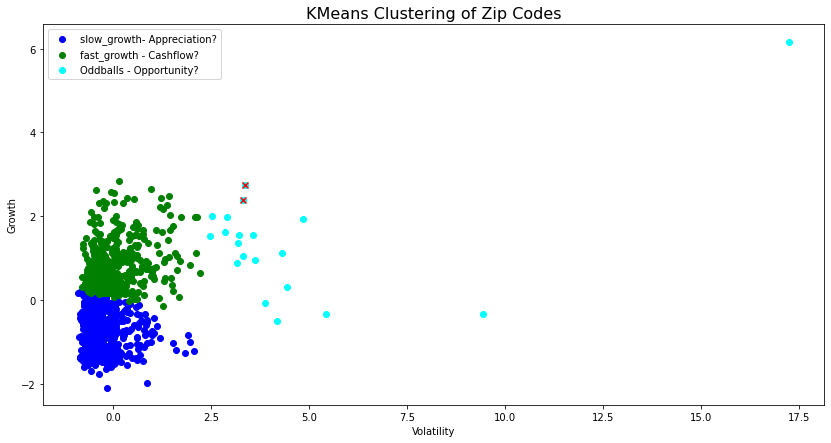

<IPython.core.display.Javascript object>

In [66]:
# plotting results
color = ["blue", "green", "cyan"]
labs = [
    "slow_growth- Appreciation?",
    "fast_growth - Cashflow?",
    "Oddballs - Opportunity?",
]
for k in range(0, 3):
    data = lof_data[lof_data["kmeans_cluster"] == k]
    plt.scatter(data["std_sigma2"], data["std_growth"], c=color[k], label=labs[k])
plt.legend(loc="upper left")
plt.xlabel("Volatility")
plt.ylabel("Growth")
plt.title("KMeans Clustering of Zip Codes", fontsize=16)
high_growth_zips = ["90265", "92253"]
chosen_zips = lof_data[lof_data.index.isin(high_growth_zips)]
plt.scatter(
    chosen_zips["std_sigma2"], chosen_zips["std_growth"], color="red", marker="x"
)
plt.show()

<AxesSubplot: xlabel='month', ylabel='zori'>

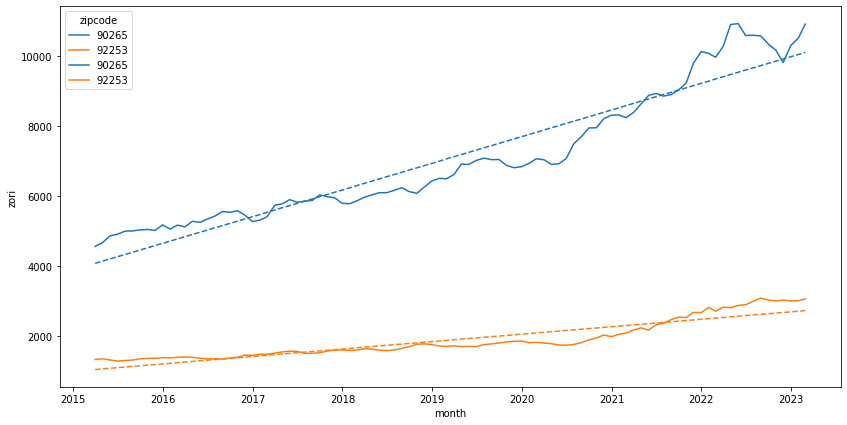

<IPython.core.display.Javascript object>

In [64]:
zcs = ["90265", "92253"]


sns.lineplot(
    data=zori_complete[zori_complete.zipcode.isin(zcs)],
    x="month",
    y="zori",
    hue="zipcode",
)
sns.lineplot(
    data=zori_complete[zori_complete.zipcode.isin(zcs)],
    x="month",
    y="zori_pred_linreg",
    hue="zipcode",
    linestyle="dashed",
)

In [44]:
lof_data.groupby(["kmeans_cluster"]).count()

,std_growth,std_sigma2,local_outlier_factor,outlier
kmeans_cluster,,,,
0,502,502,502,502
1,394,394,394,394
2,20,20,20,20


<IPython.core.display.Javascript object>

-------------

## Changepoint Detection:

In [51]:
reno = zori_complete[zori_complete.zipcode == "89509"].copy()
# identify breakpoint by hand ' Looks like 2017-01-31'

<IPython.core.display.Javascript object>

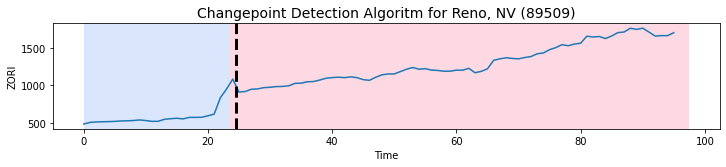

<IPython.core.display.Javascript object>

In [68]:
algo = rpt.Pelt(model="rbf").fit(reno.zori.to_numpy())
result = algo.predict(pen=20)
rpt.display(reno.zori, [24, 98], result)
ax = plt.gca()
_ = ax.set_title("Changepoint Detection Algoritm for Reno, NV (89509)", fontsize=14)
_ = ax.set_xlabel("Time")
_ = ax.set_ylabel("ZORI")
# _ = ax.set_subtitle("foo")

Pretty Neat, Ruptures found the changepoint within one month of when it occured

---------------

In [69]:
wa_data = zori[zori.zipcode == "98004"]
wa_data.set_index("month", inplace=True)
wa_data = wa_data.asfreq("M")
wa_data["time_periods"] = np.round(
    (wa_data.index - wa_data.index.min()) / np.timedelta64(1, "M")
).astype("int")
wa_data.head()

,zipcode,SizeRank,State,City,Metro,CountyName,zori,time_periods
month,,,,,,,,
2015-03-31,98004,2280,WA,Bellevue,"Seattle-Tacoma-Bellevue, WA",King County,1936.065570,0
2015-04-30,98004,2280,WA,Bellevue,"Seattle-Tacoma-Bellevue, WA",King County,1994.690249,1
2015-05-31,98004,2280,WA,Bellevue,"Seattle-Tacoma-Bellevue, WA",King County,2023.182831,2
2015-06-30,98004,2280,WA,Bellevue,"Seattle-Tacoma-Bellevue, WA",King County,2044.498418,3
2015-07-31,98004,2280,WA,Bellevue,"Seattle-Tacoma-Bellevue, WA",King County,2031.146921,4


<IPython.core.display.Javascript object>

In [70]:
reg = LinearRegression().fit(X=wa_data[["time_periods"]], y=wa_data.zori)
bellevue_preds = reg.predict(wa_data[["time_periods"]])

<IPython.core.display.Javascript object>

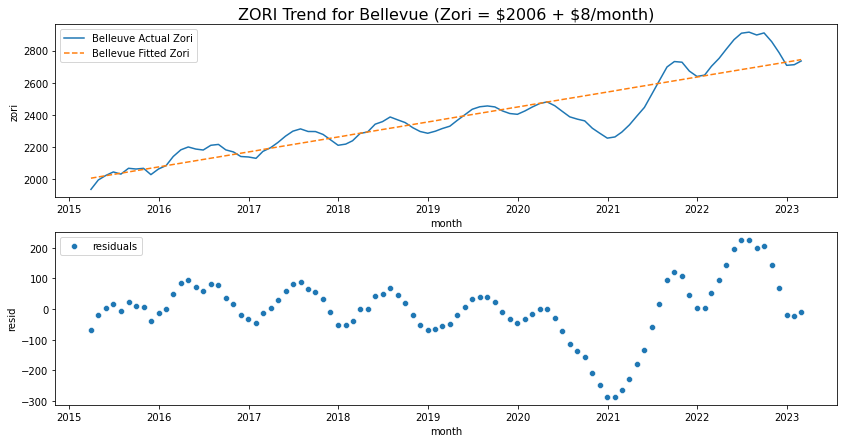

<IPython.core.display.Javascript object>

In [71]:
temp = wa_data.copy()
reg = LinearRegression().fit(X=temp[["time_periods"]], y=temp.zori)
temp["zori_fit"] = reg.predict(temp[["time_periods"]])
temp.reset_index(inplace=True)
temp["resid"] = temp["zori"] - temp["zori_fit"]
fig, (ax1, ax2) = plt.subplots(2, 1)
g = sns.lineplot(
    data=temp,
    x="month",
    y="zori",
    linestyle="solid",
    ax=ax1,
    label="Belleuve Actual Zori",
)
_ = sns.lineplot(
    data=temp,
    x="month",
    y="zori_fit",
    linestyle="dashed",
    ax=ax1,
    label="Bellevue Fitted Zori",
)
_ = sns.scatterplot(data=temp, x="month", y="resid", ax=ax2, label="residuals")
bv_int = round(reg.intercept_)
bv_slope = round(reg.coef_[0])
_ = g.set_title(f"ZORI Trend for Bellevue (Zori = \${bv_int} + \${bv_slope}/month)", fontsize=16)


(array([1220.,  504.,  293.,  219.,  140.,   55.,   92.,  562., 1020.,
        1795.]),
 array([ 0. ,  9.5, 19. , 28.5, 38. , 47.5, 57. , 66.5, 76. , 85.5, 95. ]),
 <BarContainer object of 10 artists>)

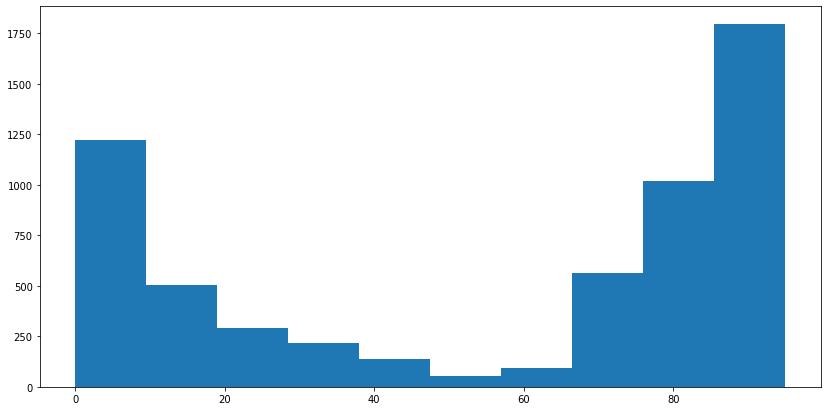

<IPython.core.display.Javascript object>

In [72]:
zori["is_zori_missing"] = zori.zori.isna()
zori_missing = zori.groupby("zipcode")["is_zori_missing"].sum().reset_index()
plt.hist(zori_missing.is_zori_missing)

In [73]:
zori_missing[zori_missing.is_zori_missing == 0].zipcode

65      02111
66      02113
67      02114
68      02115
69      02116
        ...  
5816    98374
5817    98375
5827    98405
5848    98516
5856    98661
Name: zipcode, Length: 916, dtype: object

<IPython.core.display.Javascript object>

In [75]:
zori_complete = zori.merge(
    zori_missing[zori_missing.is_zori_missing == 0], on=["zipcode"], how="inner"
)

<IPython.core.display.Javascript object>

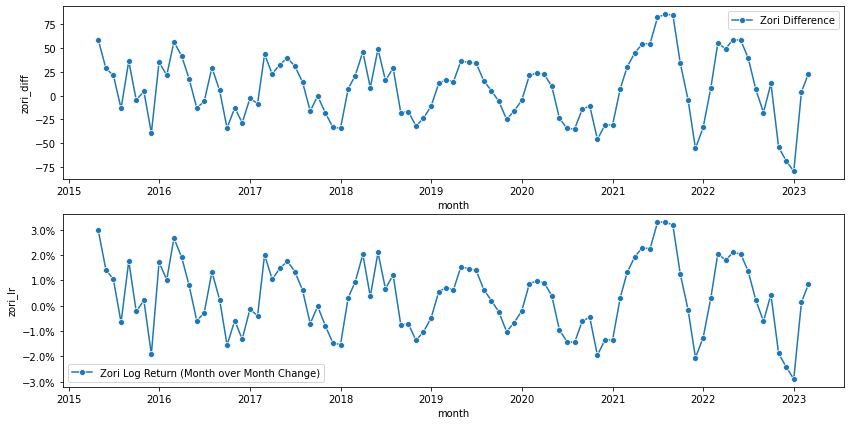

<IPython.core.display.Javascript object>

In [76]:
wa_data["zori_diff"] = wa_data.zori.diff()
wa_data["zori_log"] = np.log(wa_data.zori)
wa_data["zori_lr"] = wa_data.zori_log.diff()
wa_data

fig, (ax1, ax2) = plt.subplots(2, 1)
g = sns.lineplot(
    data=wa_data.reset_index(),
    x="month",
    y="zori_diff",
    ax=ax1,
    marker="o",
    label="Zori Difference",
)
_ = sns.lineplot(
    data=wa_data.reset_index(),
    x="month",
    y="zori_lr",
    ax=ax2,
    marker="o",
    label="Zori Log Return (Month over Month Change)",
)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

-----------------

## Check for Stationarity

Arima models assume the data is stationary, so we'll check these assumptions on the log return variable

The Augmented Dickey Fuller Test has a null hypothesis that a unit root is present (i.e. the data is non-stationary) and the alternative is that the time series does not have a unit root and therefore it is stationary.

The cell below executes the dickey fuller test with a constant.  Since we already log returned the data, there should be no linear trend present, and the log return cycles around 0 so there should be no constant needed in the regression.  Here we fit an adf test to the data and see a marginally significant p-value.  Thus we can reject the null hypothesis that the log_return data is non-stationary.

Since the ADF test gave us a borderline result, I'll try a KPSS test as well.  Contrary to most tests, the KPSS test has a null hypthesis that the data are stationary, and the alternative is that the data are not stationary. If we fit a KPSS test we get a pvalue of 0.1. We don't have enough evidence to reject the null hypothesis that the log return is stationary.

This KPSS test confirms our conclusion from ADFuller, and we can go on with ARIMA modeling.

In [77]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(wa_data.iloc[1:][['zori_lr']], regression='n')
# result = adfuller(wa_data.iloc[1:][['zori']], regression='ct')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -2.015038
p-value: 0.042006
Critical Values:
	1%: -2.593
	5%: -1.945
	10%: -1.614


<IPython.core.display.Javascript object>

In [78]:
from statsmodels.tsa.stattools import kpss

result = kpss(wa_data.iloc[1:][["zori_lr"]], regression="c")
print(f"KPSS Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Lags: {result[2]}")
print("Critical Values:")
for key, value in result[3].items():
    print("\t%s: %.3f" % (key, value))

KPSS Statistic: 0.05480521377530337
p-value: 0.1
Lags: 4
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/home/allen/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


<IPython.core.display.Javascript object>

-----------------

In [79]:
import pandas as pd
import pmdarima as pm
from pmdarima.arima import ARIMA


# Fit an ARIMA model using the pmdarima auto_arima function
model = pm.auto_arima(wa_data.iloc[1:].zori_lr, seasonal=False, error_action='ignore')

# Print the optimal values of p and q determined by the auto_arima function
print("Optimal values of p and q:", model.order)



Optimal values of p and q: (1, 0, 3)


<IPython.core.display.Javascript object>

In [80]:
# Fit an ARIMA model using the optimal values of p and q
arima_model = ARIMA(order=model.order, seasonal_order=(0,0,0,0))
arima_model.fit(wa_data.iloc[1:][['zori_lr']].to_numpy())

# Make predictions using the ARIMA model
predictions = arima_model.predict(n_periods=12)

# Print the predicted values
print("Predicted values:", predictions)


Predicted values: [0.01000109 0.00441154 0.00433696 0.00416538 0.0040256  0.00391172
 0.00381895 0.00374337 0.0036818  0.00363163 0.00359077 0.00355748]


/home/allen/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<IPython.core.display.Javascript object>

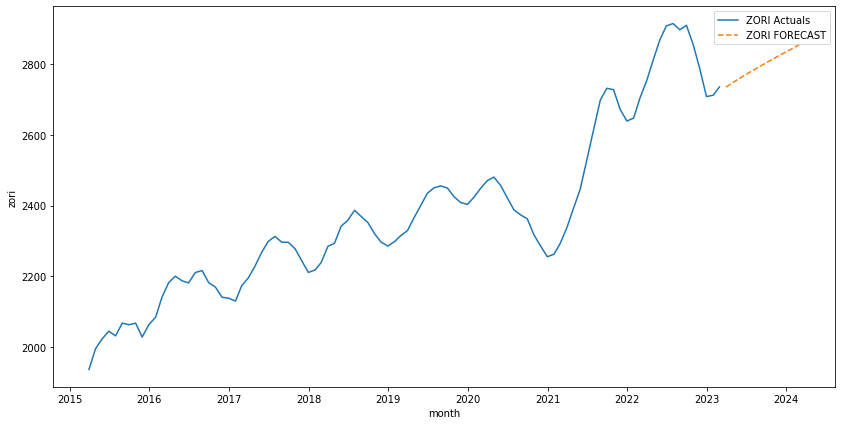

<IPython.core.display.Javascript object>

In [81]:
orig_preds = np.exp(predictions)
anchor = wa_data.zori[wa_data.index == wa_data.index.max()]
pred_df = pd.DataFrame(
    {
        "month": pd.date_range("2023-03-30", "2024-03-01", freq="M"),
        "zori_diff_pred": orig_preds,
    }
)

# Assuming your log returns are stored in a variable called 'log_returns'
# Convert log returns to original values
original_values = [anchor.values[0]]  # assuming X_0 is known
for i in range(1, len(orig_preds)):
    original_values.append(original_values[i - 1] * orig_preds[i])

pred_df["zori_pred"] = original_values
# Print the results
# print(original_values)


g = sns.lineplot(
    data=wa_data.reset_index(),
    x="month",
    y="zori",
    linestyle="solid",
    label="ZORI Actuals",
)
_ = sns.lineplot(
    data=pred_df, x="month", y="zori_pred", linestyle="dashed", label="ZORI FORECAST"
)

-----------------

## 6 Month Horizon

We want to assess how well an ARMA model on log return can predict the zori index 6 months in the future

Let's reserve 2015 through 2018 for model selection (i.e. chosing p and q in the ARMA(p,q))

Then we can evaluate the 6 month predictions with a fixed window TSCV.  Though our ARMA model will forecast on the log return scale, we will assess accuracy on the original ZORI scale.

In [82]:
# Tuning Model
tune_data = wa_data[:"2018"].copy()
tune_data = tune_data[tune_data.zori_lr.notna()]

<IPython.core.display.Javascript object>

In [83]:
tune_model = pm.auto_arima(tune_data.zori_lr, seasonal=False, error_action="ignore")
print("Optimal values of p and q:", tune_model.order)
arma_mod = sm.tsa.arima.ARIMA(tune_data.zori_lr, order=tune_model.order)
res = arma_mod.fit(method="innovations_mle")
print(res.summary())

Optimal values of p and q: (2, 0, 2)
                               SARIMAX Results                                
Dep. Variable:                zori_lr   No. Observations:                   45
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 148.699
Date:                Thu, 23 Mar 2023   AIC                           -285.398
Time:                        22:38:10   BIC                           -274.558
Sample:                    04-30-2015   HQIC                          -281.357
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.003      1.395      0.163      -0.002       0.010
ar.L1         -0.4555      0.173     -2.627      0.009      -0.795      -0.116
ar.L2          

<IPython.core.display.Javascript object>

In [84]:
res.predict(start="2023-01-31", end="2023-07-31")
# res.predict(start=1, end=3)

2023-01-31    0.003973
2023-02-28    0.003973
2023-03-31    0.003973
2023-04-30    0.003973
2023-05-31    0.003973
2023-06-30    0.003973
2023-07-31    0.003973
Freq: M, Name: predicted_mean, dtype: float64

<IPython.core.display.Javascript object>

,lb_stat,lb_pvalue
4,1.001258,0.909605


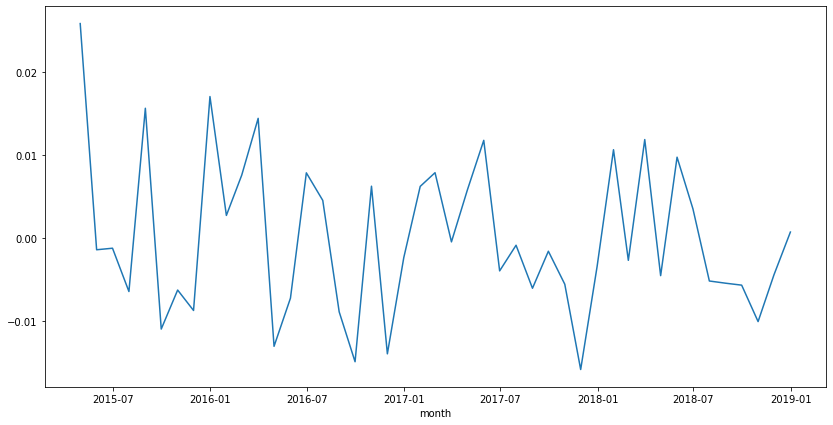

<IPython.core.display.Javascript object>

In [85]:
sns.lineplot(res.resid)
sm.stats.acorr_ljungbox(res.resid, lags=[4], return_df=True)

Since the Ljung Box test is not significant, we can assume there is no autocorrelation in the residuals, 
This suggests the Arima model fits well. 

In [86]:
# On a rolling basis, make predictions 6 months into the future
# Save Results in a dataframe with the log ratio forecast, original scale forecast, horizon
val_df_list = []
for version_month in wa_data["2019":].index:
    train_data = wa_data[:version_month]
    train_data = train_data.iloc[1:]
    # print(f"version_month: {version_month}")
    mod = sm.tsa.arima.ARIMA(train_data.zori_lr, order=tune_model.order)
    fitted_mod = mod.fit(method="innovations_mle")
    fcst_months = pd.date_range(
        start=version_month, periods=7, freq="M", inclusive="right"
    )
    fcst_start = fcst_months.min()
    fcst_end = fcst_months.max()
    fcst = fitted_mod.predict(start=fcst_start, end=fcst_end)
    anchor = wa_data[version_month:version_month].zori.values[0]
    fcst_orig_scale = np.exp(fcst)
    for i in range(len(fcst)):
        fcst_orig_scale[i] = anchor * fcst_orig_scale[i]
        anchor = fcst_orig_scale[i]

    fcst_df = pd.DataFrame(
        {
            "version_month": version_month,
            "target_month": fcst_months,
            "horizon": range(1, 7),
            "zori_lr_pred": fcst.reset_index(drop=True),
            "zori_pred": fcst_orig_scale.reset_index(drop=True),
        }
    )
    val_df_list.append(fcst_df)

val_df = pd.concat(val_df_list)
actuals_data = wa_data.reset_index().copy()
actuals_data = actuals_data.rename(
    columns={"month": "target_month", "zori": "zori_actual"}
)[["target_month", "zori_actual"]]
actuals_data
val_df = val_df.merge(actuals_data, on=["target_month"], how="outer")
val_df.sort_values(["target_month", "version_month"], inplace=True)
val_df

,version_month,target_month,horizon,zori_lr_pred,zori_pred,zori_actual
300,NaT,2015-03-31,NaN,NaN,NaN,1936.065570
301,NaT,2015-04-30,NaN,NaN,NaN,1994.690249
302,NaT,2015-05-31,NaN,NaN,NaN,2023.182831
303,NaT,2015-06-30,NaN,NaN,NaN,2044.498418
304,NaT,2015-07-31,NaN,NaN,NaN,2031.146921
...,...,...,...,...,...,...
295,2023-01-31,2023-06-30,5.0,0.003692,2792.859269,NaN
296,2023-02-28,2023-06-30,4.0,0.004027,2809.243606,NaN
297,2023-01-31,2023-07-31,6.0,0.004154,2804.485500,NaN
298,2023-02-28,2023-07-31,5.0,0.004177,2821.002200,NaN


<IPython.core.display.Javascript object>

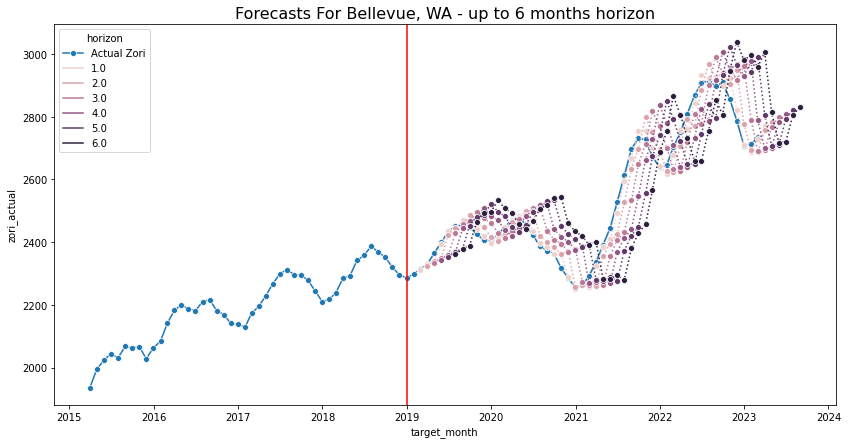

<IPython.core.display.Javascript object>

In [87]:
fig, ax = plt.subplots(1, 1)

g = sns.lineplot(
    data=val_df,
    x="target_month",
    y="zori_actual",
    # hue="horizon",
    linestyle="solid",
    marker="o",
    ax=ax,
    label="Actual Zori",
)
ax.axvline(pd.to_datetime("2019-01-01"), color="red")
_ = sns.lineplot(
    data=val_df,
    x="target_month",
    y="zori_pred",
    hue="horizon",
    linestyle="dotted",
    marker="o",
    ax=ax,
    # label='Forecasted Zori'
)
_ = g.set_title("Forecasts For Bellevue, WA - up to 6 months horizon", fontsize=16)

In [88]:
val_df["perc_error"] = (val_df["zori_actual"] - val_df["zori_pred"]) / val_df[
    "zori_actual"
]
val_df["abs_perc_error"] = abs(val_df["perc_error"])
val_df.groupby(["horizon"]).agg(mape=("abs_perc_error", np.mean))

,mape
horizon,
1.0,0.006750
2.0,0.016401
3.0,0.029290
4.0,0.040055
5.0,0.049013
6.0,0.054880


<IPython.core.display.Javascript object>

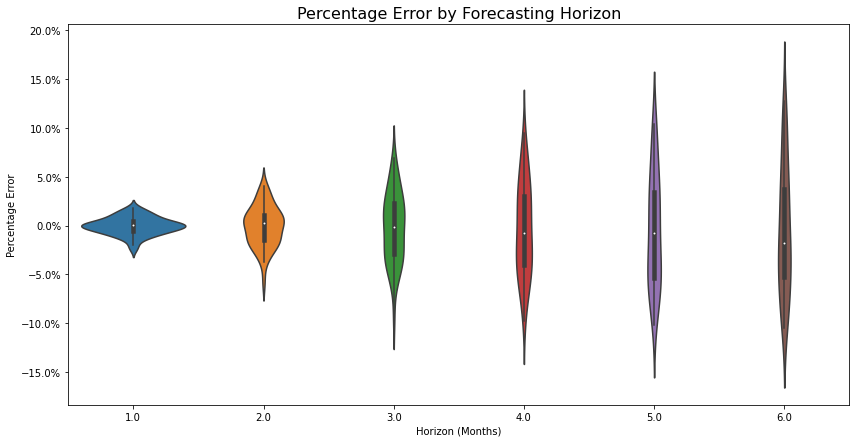

<IPython.core.display.Javascript object>

In [89]:
val_df["horizon_group"] = pd.Categorical(val_df.horizon)
fig, ax = plt.subplots(1, 1)


g = sns.violinplot(data=val_df, y="perc_error", x="horizon_group", ax=ax)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
_ = g.set_title("Percentage Error by Forecasting Horizon", fontsize=16)
_ = g.set_ylabel("Percentage Error")
_ = g.set_xlabel("Horizon (Months)")

----------------------------------

In [90]:
# rental listings
listings = pd.read_csv(
    "/home/allen/Documents/code/rffetch/data/rentals/92253/2023-03-23/rental_properties.csv"
)

<IPython.core.display.Javascript object>

In [91]:
listings

,address,rent,beds,baths,area,url
0,Mediterra Apartments Homes | 43100 Palm Royale...,"$2,125-$2,650/mo",1-2 Bed,1-2 Bath,"755-1,027 Sq. Ft.",www.redfin.com//CA/La-Quinta/Mediterra-Apartme...
1,Silverhawk Apartment Homes at La Quinta | 5066...,"$1,800-$2,605/mo",1-3 Bed,1-2 Bath,"670-1,177 Sq. Ft.",www.redfin.com//CA/La-Quinta/Silverhawk-Apartm...
2,"54015 Southern Hls, La Quinta, CA 92253","$8,500/mo",5 Beds,3.5 Baths,"3,818 Sq. Ft.",www.redfin.com//CA/La-Quinta/54015-Southern-Hl...
3,"45210 Desert Sand Ct, La Quinta, CA 92253","$2,700/mo",4 Beds,3 Baths,"2,060 Sq. Ft.",www.redfin.com//CA/La-Quinta/45210-Desert-Sand...
4,"Golf View Dr, La Quinta, CA 92253","$15,000/mo",4 Beds,4.5 Baths,"3,222 Sq. Ft.",www.redfin.com//CA/La-Quinta/Golf-View-Dr-9225...
...,...,...,...,...,...,...
106,"81280 National Dr, La Quinta, CA 92253","$20,000/mo",5 Beds,5.5 Baths,"3,980 Sq. Ft.",www.redfin.com//CA/La-Quinta/81280-National-Dr...
107,"55281 Shoal Crk Unit PGA, La Quinta, CA 92253","$4,900/mo",3 Beds,2 Baths,—Sq. Ft.,www.redfin.com//CA/La-Quinta/55281-Shoal-Crk-9...
108,"81730 Andalusia, La Quinta, CA 92253","$15,000/mo",4 Beds,5 Baths,"3,280 Sq. Ft.",www.redfin.com//CA/La-Quinta/81730-Andalusia-9...
109,"55459 Tanglewood Unit N/A, La Quinta, CA 92253","$4,985/mo",2 Beds,2 Baths,"1,283 Sq. Ft.",www.redfin.com//CA/La-Quinta/55459-Tanglewood-...


<IPython.core.display.Javascript object>